## A simple Pytorch Tutorial for binary classification.


In this tutorial, we will explore how to build a custom Pytorch CNN with a sklearn-like API.  

Let's get started!


### Creating the Dataset 



We will create a dataset comprising images of the digits 0 and 1. These images will serve as training data for a basic neural network tasked with classifying these digits.
<br>

Specifically, X will represent a numpy array with dimensions (Number_of_images x 28 x 28 x 3), while y will be a numpy array sized (Number_of_images x 1).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


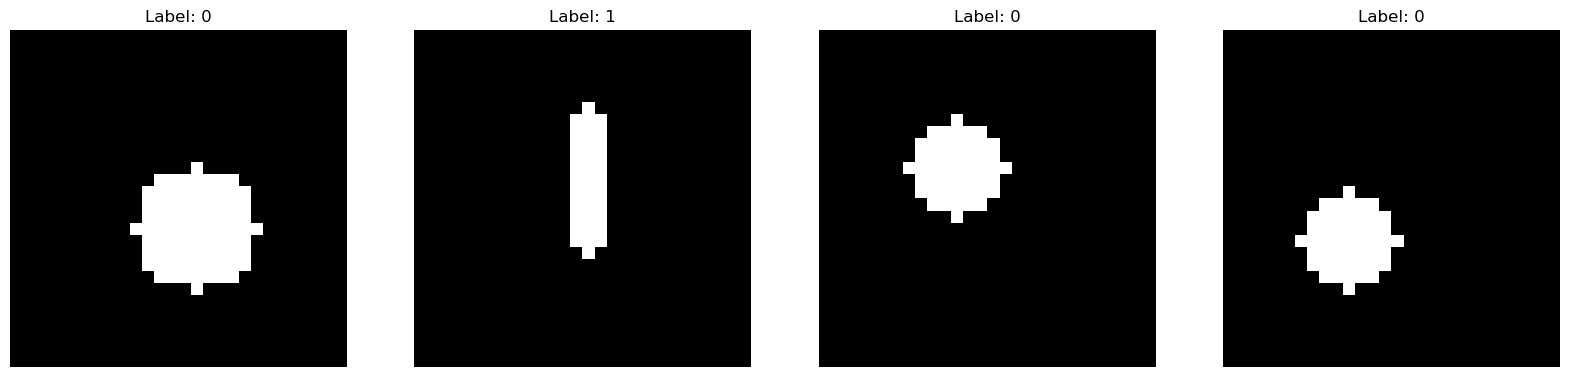

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import cv2


# Function to generate an image of digit 0 with random size and position
def generate_zero_image(image_size):
    image = np.zeros((image_size, image_size, 3), dtype=np.float32)
    size = np.random.randint(image_size // 2, image_size)  # Random size for digit 0
    x_pos = np.random.randint(0, image_size - size)
    y_pos = np.random.randint(0, image_size - size)
    color = np.random.randint(0, 256, size=3)  # Random color
    cv2.circle(image, (x_pos + size // 2, y_pos + size // 2), size // 4, color.tolist(), thickness=-1)
    return image

# Function to generate an image of digit 1 with random size and position
def generate_one_image(image_size):
    image = np.zeros((image_size, image_size, 3), dtype=np.float32)
    size = np.random.randint(image_size // 4, image_size // 2)  # Random size for digit 1
    x_pos = np.random.randint(0, image_size - size)
    y_pos = np.random.randint(0, image_size - size)
    color = np.random.randint(0, 256, size=3)  # Random color
    cv2.line(image, (x_pos + size // 2, y_pos), (x_pos + size // 2, y_pos + size), color.tolist(), thickness=size // 4)
    return image

# Generate dataset
num_samples = 1000  # Number of samples
image_size = 28     # Image size

X = []  # List to store images
y = []  # List to store labels

# Generate samples of digit 0
for _ in range(num_samples // 2):
    image = generate_zero_image(image_size)
    X.append(np.transpose(image))
    y.append([0])

# Generate samples of digit 1
for _ in range(num_samples // 2):
    image = generate_one_image(image_size)
    X.append(np.transpose(image))
    y.append([1])

# Convert lists to NumPy arrays
X = np.array(X)
y = np.array(y)

# Shuffle the dataset
indices = np.arange(len(X))
np.random.shuffle(indices)

# X is a numpy array of size (Number_of_samplesx28x28x3)
X = X[indices]
y = y[indices]


# plot the first 4 images of the dataset
fig, ax = plt.subplots(1, 4, figsize=(20, 20))
for i in range(4):
    ax[i].imshow(np.transpose(X[i]))
    ax[i].set_title(f"Label: {y[i][0]}")
    ax[i].axis("off")
plt.show()


In [34]:
# Split the dataset into training and testing sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Creating the Pytorch Dataset 

Now we're going to dive into creating a Dataset compatible with PyTorch. This step is crucial as it allows us to integrate our data, represented by X and y, into the PyTorch ecosystem. We will be able to utilize powerful PyTorch tools such as data loaders, which are essential for efficiently handling and processing our dataset during training.

In [3]:
import torch
from torch.utils.data import Dataset

In [4]:
# this block of code is used to create a custom dataset class compatible with pytorch

class CustomDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):

        if self.transform:
            X_transform = self.transform(X[idx])
            y_transform = self.transform(y[idx])

        return X_transform, y_transform

In [35]:
import torchvision.transforms as transforms

from torch.utils.data import DataLoader

In [36]:
# to_tensor doesn't work to convert numpy images into torch tensors

transform = torch.from_numpy

batch_size = 4

train_dataset = CustomDataset(X_train, y_train,
                              transform=transform)

test_dataset = CustomDataset(X_test, y_test,
                             transform=transform)

train_loader = DataLoader(train_dataset,
                          batch_size=batch_size)

test_loader = DataLoader(test_dataset,
                         batch_size=batch_size)

### Creating the CNN

In [8]:
import torch.nn as nn

In [9]:
# Define the neural network architecture

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(

            nn.Conv2d(3, 6, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten(),
            nn.Linear(256, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10),
            nn.ReLU(),
            nn.Linear(10, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.network(x)
        return x


In [37]:
net = Net()

In [40]:
# construction of the CNN solver with a sklearn like API

class CNN:
    def __init__(self, model, criterion, optimizer):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer

    def fit(self, train_loader, n_epochs=2):
        self.model.train()
        for epoch in range(n_epochs):
            running_loss = 0.0
            compteur = 0
            l = len(train_loader)
            for X, y in train_loader:

                self.optimizer.zero_grad()
                outputs = self.model(X)

                # convert the outputs and the labels to float32 to pass it to the loss
                outputs = outputs.to(torch.float32)
                y = y.to(torch.float32)

                loss = self.criterion(outputs, y)
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item()
                if compteur % l  == l-1:
                    print(f'[{epoch + 1}, {compteur + 1:5d}]',
                          f'train_loss: {running_loss /l :.3f}')
                compteur+=1

        print('Finished Training')

    def predict(self, test_loader):
        self.model.eval()
        predictions = []
        with torch.no_grad():
            for X, _ in test_loader:
                inputs = X
                outputs = self.model(inputs)
                binary_predictions = (outputs >= 0.5).float()
                predictions.extend(binary_predictions.cpu().numpy().tolist())

        return predictions

    # return by default the accuracy score of the model

    def score(self, test_loader):
        predictions = self.predict(test_loader)
        y_true = [y for _, y in test_loader]
        y_true = torch.cat(y_true, dim=0).cpu().numpy()
        return np.mean(y_true == predictions)


In [12]:
import torch.optim as optim

In [39]:
# For binary classification, it is a common pratice to use the Binary Cross Entropy loss

criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.5)

clf = CNN(model=net,
          criterion=criterion,
          optimizer=optimizer)


In [20]:
clf.fit(train_loader, n_epochs=20)


[1,   200] train_loss: 0.196
[2,   200] train_loss: 0.174
[3,   200] train_loss: 0.155
[4,   200] train_loss: 0.138
[5,   200] train_loss: 0.124
[6,   200] train_loss: 0.110
[7,   200] train_loss: 0.099
[8,   200] train_loss: 0.089
[9,   200] train_loss: 0.081
[10,   200] train_loss: 0.073
[11,   200] train_loss: 0.066
[12,   200] train_loss: 0.060
[13,   200] train_loss: 0.055
[14,   200] train_loss: 0.051
[15,   200] train_loss: 0.047
[16,   200] train_loss: 0.043
[17,   200] train_loss: 0.040
[18,   200] train_loss: 0.037
[19,   200] train_loss: 0.035
[20,   200] train_loss: 0.032
Finished Training


In [19]:
clf.score(test_loader)

0.955

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[0.0006]], grad_fn=<SigmoidBackward0>)


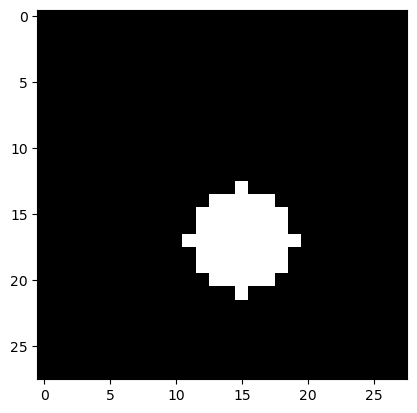

In [28]:
image = test_dataset[30]

# ploting the image

plt.imshow(np.transpose(image[0]))

# prediction of the model

print(clf.model(image[0].unsqueeze(0)))